# Random Forest

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt

import sklearn
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model as lm
from sklearn import model_selection as ms
sklearn.set_config(print_changed_only=False)

import copy

import import_ipynb

from _Self_Written_Functions_Sheet import (conditions_edit, nbrhd_rank, drop_nbrhd,
totallivsf_add, drop_grlivarea, bsmtfin_add, drop_bsmtfinsf12, totalporchsf_add,
drop_porches, yrsremodtosold_add, drop_yrsoldremod, fireplace_yes, drop_fireplaces,
pool_yes, drop_poolarea, totalbaths_add, drop_baths, totalbsmtbaths_add,
drop_bsmtbaths)

from _Self_Written_Functions_Sheet import (dum_scale, use_og_data, comb_list_generator,
                                           apply_comb_list, rmse)

importing Jupyter notebook from _Self_Written_Functions_Sheet.ipynb


In [50]:
hp_train = pd.read_csv('..\hp_2a_ranked_edited_train.csv', index_col=0)
hp_test = pd.read_csv('..\hp_2a_ranked_edited_test.csv', index_col=0)
hp_logsp = pd.read_csv('..\hp_1a_no_imputation_logsaleprice.csv', index_col=0)
hp_saleprice = pd.read_csv('..\hp_1a_no_imputation_saleprice.csv', index_col=0)

# saving train index
hp_index = hp_train.index

combo_nonedit = pd.concat([hp_train, hp_test])
combo_nonedit.columns = hp_train.columns

# convert all possible numeric types to numeric
for col in combo_nonedit.columns: 
    combo_nonedit[col] = combo_nonedit[col].astype('float', errors='ignore')

combo_cols = list(combo_nonedit.columns)

combo = copy.deepcopy(combo_nonedit)

combo

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,2-STORY 1946 & NEWER,RL,65.0,8450.0,1.0,0.0,Reg,Lvl,3.0,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7.0,5.0,2003.0,2003.0,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,4.0,3.0,PConc,4.0,3.0,1.0,6.0,706.0,1.0,0.0,150.0,856.0,GasA,5.0,1.0,5.0,856.0,854.0,0.0,1710.0,1.0,0.0,2.0,1.0,3.0,1.0,4.0,8.0,7.0,0.0,None,Attchd,2003.0,2.0,2.0,548.0,3.0,3.0,3.0,0.0,61.0,0.0,0.0,0.0,0.0,0.0,0.0,None,0.0,Feb,2008.0,WD,Normal
1,1-STORY 1946 & NEWER ALL STYLES,RL,80.0,9600.0,1.0,0.0,Reg,Lvl,3.0,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6.0,8.0,1976.0,1976.0,Gable,CompShg,MetalSd,MetalSd,None,0.0,3.0,3.0,CBlock,4.0,3.0,4.0,5.0,978.0,1.0,0.0,284.0,1262.0,GasA,5.0,1.0,5.0,1262.0,0.0,0.0,1262.0,0.0,1.0,2.0,0.0,3.0,1.0,3.0,6.0,7.0,1.0,TA,Attchd,1976.0,2.0,2.0,460.0,3.0,3.0,3.0,298.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,0.0,May,2007.0,WD,Normal
2,2-STORY 1946 & NEWER,RL,68.0,11250.0,1.0,0.0,IR1,Lvl,3.0,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7.0,5.0,2001.0,2002.0,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,4.0,3.0,PConc,4.0,3.0,2.0,6.0,486.0,1.0,0.0,434.0,920.0,GasA,5.0,1.0,5.0,920.0,866.0,0.0,1786.0,1.0,0.0,2.0,1.0,3.0,1.0,4.0,6.0,7.0,1.0,TA,Attchd,2001.0,2.0,2.0,608.0,3.0,3.0,3.0,0.0,42.0,0.0,0.0,0.0,0.0,0.0,0.0,None,0.0,Sep,2008.0,WD,Normal
3,2-STORY 1945 & OLDER,RL,60.0,9550.0,1.0,0.0,IR1,Lvl,3.0,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7.0,5.0,1915.0,1970.0,Gable,CompShg,Wd Sdng,WdShing,None,0.0,3.0,3.0,BrkTil,3.0,4.0,1.0,5.0,216.0,1.0,0.0,540.0,756.0,GasA,4.0,1.0,5.0,961.0,756.0,0.0,1717.0,1.0,0.0,1.0,0.0,3.0,1.0,4.0,7.0,7.0,1.0,Gd,Detchd,1998.0,1.0,3.0,642.0,3.0,3.0,3.0,0.0,35.0,272.0,0.0,0.0,0.0,0.0,0.0,None,0.0,Feb,2006.0,WD,Abnorml
4,2-STORY 1946 & NEWER,RL,84.0,14260.0,1.0,0.0,IR1,Lvl,3.0,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8.0,5.0,2000.0,2000.0,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,4.0,3.0,PConc,4.0,3.0,3.0,6.0,655.0,1.0,0.0,490.0,1145.0,GasA,5.0,1.0,5.0,1145.0,1053.0,0.0,2198.0,1.0,0.0,2.0,1.0,4.0,1.0,4.0,9.0,7.0,1.0,TA,Attchd,2000.0,2.0,3.0,836.0,3.0,3.0,3.0,192.0,84.0,0.0,0.0,0.0,0.0,0.0,0.0,None,0.0,Dec,2008.0,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2912,2-STORY PUD - 1946 & NEWER,RM,21.0,1936.0,1.0,0.0,Reg,Lvl,3.0,Inside,Gtl,MeadowV,Norm,Norm,TwnhsI,2Story,4.0,7.0,1970.0,1970.0,Gable,CompShg,CemntBd,CemntBd,None,0.0,3.0,3.0,CBlock,3.0,3.0,1.0,1.0,0.0,1.0,0.0,546.0,546.0,GasA,4.0,1.0,5.0,546.0,546.0,0.0,1092.0,0.0,0.0,1.0,1.0,3.0,1.0,3.0,5.0,7.0,0.0,None,None,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,0.0,Jun,2006.0,WD,Normal
2913,2-STORY PUD - 1946 & NEWER,RM,21.0,1894.0,1.0,0.0,Reg,Lvl,3.0,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4.0,5.0,1970.0,1970.0,Gable,CompShg,CemntBd,CemntBd,None,0.0,3.0,3.0,CBlock,3.0,3.0,1.0,3.0,252.0,1.0,0.0,294.0,546.0,GasA,3.0,1.0,5.0,546.0,546.0,0.0,1092.0,0.0,0.0,1.0,1.0,3.0,1.0,3.0,6.0,7.0,0.0,None,CarPort,1970.0,1.0,1.0,286.0,3.0,3.0,3.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.

In [52]:
# make copies of the original df to edit each individually according to the best scores/feat eng pair
rfr_df = copy.deepcopy(combo_nonedit)

# copy and paste the functions from the dictionary results above
rfr_feat_eng = [totallivsf_add, bsmtfin_add, yrsremodtosold_add, totalbaths_add, totalbsmtbaths_add,
                drop_porches, drop_yrsoldremod, drop_fireplaces, drop_poolarea, drop_bsmtbaths]

for feat in rfr_feat_eng:
    feat(rfr_df)

# dummify and scale the dataset
hp_full_strd = copy.deepcopy(dum_scale(rfr_df))

hp_full_strd_to_use = copy.deepcopy(hp_full_strd.loc[hp_index])

hp_full_strd_to_use

,TotalBsmtBaths,TotalBaths,YrsRemodToSold,BsmtFin,TotalLivSF,LotFrontage,LotArea,Street,Alley,Utilities,OverallQual,OverallCond,YearBuilt,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,PoolQC,Fence,MiscVal,MSSubClass_1-1/2 STORY FINISHED ALL AGES,MSSubClass_1-1/2 STORY PUD - ALL AGES,MSSubClass_1-STORY 1945 & OLDER,MSSubClass_1-STORY 1946 & NEWER ALL STYLES,MSSubClass_1-STORY PUD (Planned Unit Development) - 1946 & NEWER,MSSubClass_1-STORY W/FINISHED ATTIC ALL AGES,MSSubClass_2 FAMILY CONVERSION - ALL STYLES AND AGES,MSSubClass_2-1/2 STORY ALL AGES,MSSubClass_2-STORY 1945 & OLDER,MSSubClass_2-STORY 1946 & NEWER,MSSubClass_2-STORY PUD - 1946 & NEWER,MSSubClass_DUPLEX - ALL STYLES AND AGES,MSSubClass_PUD - MULTILEVEL - INCL SPLIT LEV/FOYER,MSSubClass_SPLIT FOYER,MSSubClass_SPLIT OR MULTI-LEVEL,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_TwnhsE,BldgType_TwnhsI,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_BrkComm,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CemntBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_WdShing,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_None,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MoSold_Aug,MoSold_Dec,MoSold_Feb,MoSold_Jan,MoSold_Jul,MoSold_Jun,MoSold_Mar,MoSold_May,MoSold_Nov,MoSold_Oct,MoSold_Sep,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.333333,0.5,0.083333,1.0,0.237373,0.150685,0.033420,1.0,0.0,1.0,0.666667,0.500,0.949275,0.122500,0.666667,0.50,0.8,0.75,0.25,1.000000,0.176060,0.166667,0.000000,0.064212,0.16

In [5]:
state = 0

# setting up train and test sets
xtrain, xtest, ytrain, ytest = ms.train_test_split(hp_full_strd_to_use,
                                                   hp_logsp,
                                                   test_size=0.2,
                                                   random_state=state)

# Must flatten to fit
ytrain = ytrain.values.flatten()

# using standard kfold split
n_folds = ms.KFold(n_splits=5, random_state=state, shuffle=True)

In [6]:
train_scores = []
test_scores = []
train_rmse = []
test_rmse = []
best_par_list = []

rfr = RandomForestRegressor(random_state=0)

# parameters to use
maxdepth = [5, 10, 20, 40, 50, 60, 100, 150, 200]
minsamlf = [1, 2, 3]
minsamsplt = [2, 3, 4]
nestimators = [100, 200, 300, 400, 500]
oobscore = [True]
warmstart = [True]


gparam_rfr = {'max_depth': maxdepth,
              'min_samples_leaf': minsamlf,
              'min_samples_split': minsamsplt,
              'n_estimators': nestimators,
              'oob_score': oobscore,
              'warm_start': warmstart}

# setting parameters
gs_rfr = ms.GridSearchCV(rfr, gparam_rfr, cv=n_folds, refit=True, n_jobs=-1,
                           scoring='neg_root_mean_squared_error', return_train_score=True)

%time gs_rfr.fit(xtrain, ytrain)

# setting up dataframe for results
train_scores.append(gs_rfr.best_estimator_.score(xtrain, ytrain))
test_scores.append(gs_rfr.best_estimator_.score(xtest, ytest))

# use rmse function from Self_Written_Functions_Sheet_Recover
train_rmse.append(rmse(gs_rfr, ytrain, xtrain))
test_rmse.append(rmse(gs_rfr, ytest, xtest))

# add the best parameters to the df
best_par_list.append(gs_rfr.best_params_)

# find the difference btwn the rmses
diff_rmse = np.subtract(train_rmse, test_rmse)

# create dataframe
rfr_list_results = [train_scores, test_scores, train_rmse, test_rmse, diff_rmse]
rfr_res_df = pd.DataFrame(rfr_list_results).T
rfr_res_df.columns = ['TrainScores', 'TestScores', 'TrainRMSE', 'TestRMSE', 'DiffRMSE']
best_par_df = pd.DataFrame(best_par_list)
rfr_res_df = pd.concat([rfr_res_df, best_par_df], axis=1, sort=False)

rfr_res_df

C:\Users\tdcho\anaconda3\envs\proj3_env\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Wall time: 17min 55s


,TrainScores,TestScores,TrainRMSE,TestRMSE,DiffRMSE,max_depth,min_samples_leaf,min_samples_split,n_estimators,oob_score,warm_start
0,0.983059,0.916158,0.051588,0.119202,-0.067613,50,1,2,500,True,True


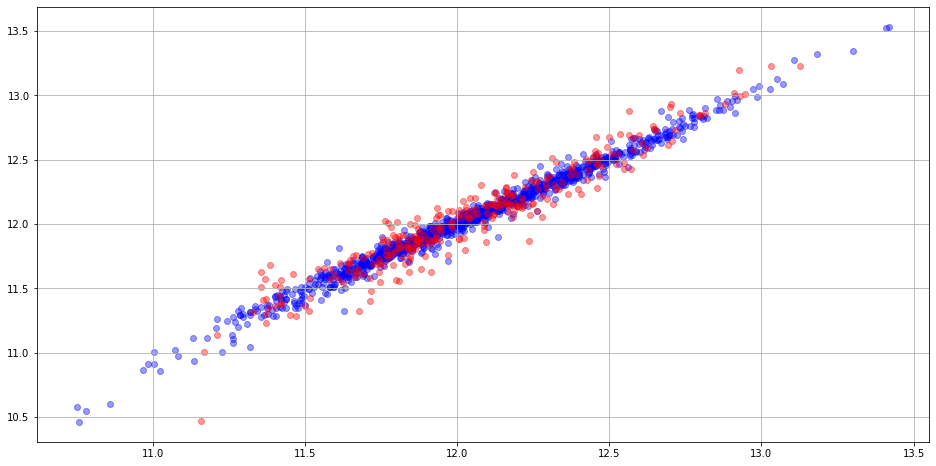

In [7]:
plt.figure(figsize=(16, 8))
plt.scatter(gs_rfr.best_estimator_.predict(xtrain), ytrain, color='blue', alpha=0.4)
plt.scatter(gs_rfr.best_estimator_.predict(xtest), ytest, color='red', alpha=0.4)
plt.grid(which='both')

In [8]:
train_scores = []
test_scores = []
train_rmse = []
test_rmse = []
best_par_list = []

# parameters to use
maxdepth = [25, 50, 60, 75, 90]
minsamlf = [1, 2, 3, 5]
minsamsplt = [2, 3, 5]
nestimators = [150, 300, 450, 500, 600, 750]
oobscore = [True, False]
warmstart = [True, False]


gparam_rfr = {'max_depth': maxdepth,
              'min_samples_leaf': minsamlf,
              'min_samples_split': minsamsplt,
              'n_estimators': nestimators,
              'oob_score': oobscore,
              'warm_start': warmstart}

# setting parameters
gs_rfr = ms.GridSearchCV(rfr, gparam_rfr, cv=n_folds, refit=True, n_jobs=-1,
                           scoring='neg_root_mean_squared_error', return_train_score=True)

%time gs_rfr.fit(xtrain, ytrain)

# setting up dataframe for results
train_scores.append(gs_rfr.best_estimator_.score(xtrain, ytrain))
test_scores.append(gs_rfr.best_estimator_.score(xtest, ytest))

# use rmse function from Self_Written_Functions_Sheet_Recover
train_rmse.append(rmse(gs_rfr, ytrain, xtrain))
test_rmse.append(rmse(gs_rfr, ytest, xtest))

# add the best parameters to the df
best_par_list.append(gs_rfr.best_params_)

# find the difference btwn the rmses
diff_rmse = np.subtract(train_rmse, test_rmse)

# create dataframe
rfr_list_results = [train_scores, test_scores, train_rmse, test_rmse, diff_rmse]
rfr_res_df = pd.DataFrame(rfr_list_results).T
rfr_res_df.columns = ['TrainScores', 'TestScores', 'TrainRMSE', 'TestRMSE', 'DiffRMSE']
best_par_df = pd.DataFrame(best_par_list)
rfr_res_df = pd.concat([rfr_res_df, best_par_df], axis=1, sort=False)

rfr_res_df

C:\Users\tdcho\anaconda3\envs\proj3_env\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Wall time: 26min 36s


,TrainScores,TestScores,TrainRMSE,TestRMSE,DiffRMSE,max_depth,min_samples_leaf,min_samples_split,n_estimators,oob_score,warm_start
0,0.983071,0.916114,0.05157,0.119233,-0.067663,25,1,2,450,True,True


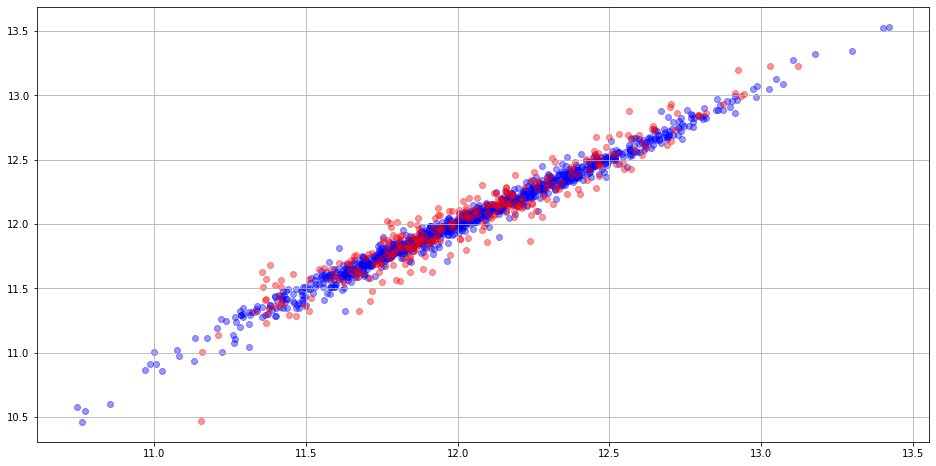

In [9]:
plt.figure(figsize=(16, 8))
plt.scatter(gs_rfr.best_estimator_.predict(xtrain), ytrain, color='blue', alpha=0.4)
plt.scatter(gs_rfr.best_estimator_.predict(xtest), ytest, color='red', alpha=0.4)
plt.grid(which='both')

In [10]:
train_scores = []
test_scores = []
train_rmse = []
test_rmse = []
best_par_list = []

# parameters to use
maxdepth = [10, 20, 25, 30, 40, 50]
minsamlf = [1]
minsamsplt = [2]
nestimators = [400, 425, 450, 475, 500]
oobscore = [True, False]
warmstart = [True, False]


gparam_rfr = {'max_depth': maxdepth,
              'min_samples_leaf': minsamlf,
              'min_samples_split': minsamsplt,
              'n_estimators': nestimators,
              'oob_score': oobscore,
              'warm_start': warmstart}

# setting parameters
gs_rfr = ms.GridSearchCV(rfr, gparam_rfr, cv=n_folds, refit=True, n_jobs=-1,
                           scoring='neg_root_mean_squared_error', return_train_score=True)

%time gs_rfr.fit(xtrain, ytrain)

# setting up dataframe for results
train_scores.append(gs_rfr.best_estimator_.score(xtrain, ytrain))
test_scores.append(gs_rfr.best_estimator_.score(xtest, ytest))

# use rmse function from Self_Written_Functions_Sheet_Recover
train_rmse.append(rmse(gs_rfr, ytrain, xtrain))
test_rmse.append(rmse(gs_rfr, ytest, xtest))

# add the best parameters to the df
best_par_list.append(gs_rfr.best_params_)

# find the difference btwn the rmses
diff_rmse = np.subtract(train_rmse, test_rmse)

# create dataframe
rfr_list_results = [train_scores, test_scores, train_rmse, test_rmse, diff_rmse]
rfr_res_df = pd.DataFrame(rfr_list_results).T
rfr_res_df.columns = ['TrainScores', 'TestScores', 'TrainRMSE', 'TestRMSE', 'DiffRMSE']
best_par_df = pd.DataFrame(best_par_list)
rfr_res_df = pd.concat([rfr_res_df, best_par_df], axis=1, sort=False)

rfr_res_df

C:\Users\tdcho\anaconda3\envs\proj3_env\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Wall time: 2min 52s


,TrainScores,TestScores,TrainRMSE,TestRMSE,DiffRMSE,max_depth,min_samples_leaf,min_samples_split,n_estimators,oob_score,warm_start
0,0.983043,0.915983,0.051613,0.119326,-0.067713,20,1,2,475,True,True


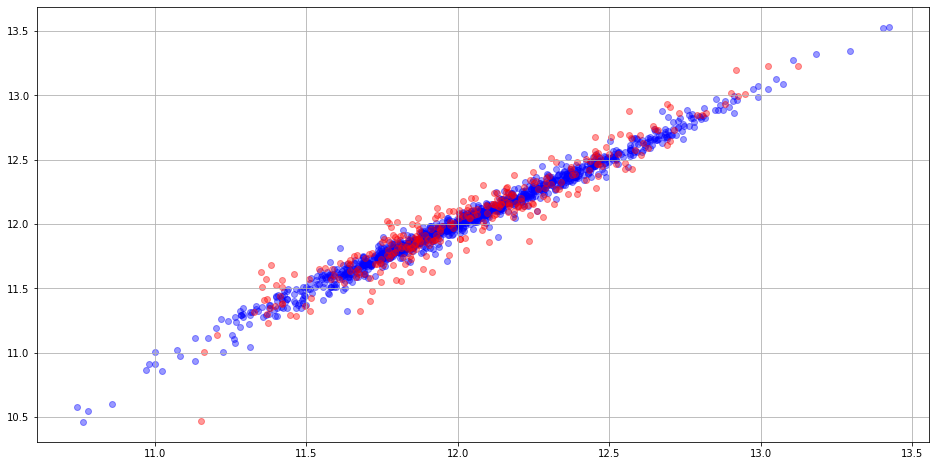

In [11]:
plt.figure(figsize=(16, 8))
plt.scatter(gs_rfr.best_estimator_.predict(xtrain), ytrain, color='blue', alpha=0.4)
plt.scatter(gs_rfr.best_estimator_.predict(xtest), ytest, color='red', alpha=0.4)
plt.grid(which='both')

### Test set is not improving

In [65]:
sorted_importance_rfr = sorted(zip(hp_full_strd_to_use.columns,
                                   gs_rfr.best_estimator_.feature_importances_),
                               key=lambda t:t[1], reverse=True)

filtered_sorted_importance_rfr = [x for x in sorted_importance_rfr if x[1]>0]

df_filter_sort_rfr = [x[0] for x in filtered_sorted_importance_rfr]

df_filter_sort_rfr

['OverallQual',
 'TotalLivSF',
 'GarageArea',
 'GrLivArea',
 'TotalBsmtSF',
 'GarageCars',
 'YrsRemodToSold',
 'YearBuilt',
 'LotArea',
 'OverallCond',
 'CentralAir',
 '1stFlrSF',
 'GarageYrBlt',
 'BsmtUnfSF',
 'FireplaceQu_None',
 'LotFrontage',
 'TotalBaths',
 'KitchenQual',
 'MSZoning_RM',
 '2ndFlrSF',
 'GarageCond',
 'GarageType_Detchd',
 'BsmtFinSF1',
 'BsmtQual',
 'ExterCond',
 'GarageFinish',
 'WoodDeckSF',
 'MasVnrArea',
 'PavedDrive',
 'GarageQual',
 'TotRmsAbvGrd',
 'Fence',
 'Functional',
 'HeatingQC',
 'ExterQual',
 'LotShape_Reg',
 'MSZoning_RL',
 'BsmtFinType1',
 'SaleCondition_Normal',
 'BsmtExposure',
 'BedroomAbvGr',
 'MoSold_Dec',
 'MSSubClass_2-STORY 1946 & NEWER',
 'GarageType_Attchd',
 'Condition1_Norm',
 'Neighborhood_IDOTRR',
 'SaleCondition_Family',
 'HalfBath',
 'FireplaceQu_Gd',
 'Neighborhood_NAmes',
 'Neighborhood_Edwards',
 'FireplaceQu_Po',
 'LotConfig_Inside',
 'KitchenAbvGr',
 'Neighborhood_OldTown',
 'RoofStyle_Gable',
 'LandContour_Lvl',
 'Exterior2nd_

In [67]:
hp_fullstrd_filtrsrt = hp_full_strd_to_use[df_filter_sort_rfr]
hp_fullstrd_filtrsrt

,OverallQual,TotalLivSF,GarageArea,GrLivArea,TotalBsmtSF,GarageCars,YrsRemodToSold,YearBuilt,LotArea,OverallCond,CentralAir,1stFlrSF,GarageYrBlt,BsmtUnfSF,FireplaceQu_None,LotFrontage,TotalBaths,KitchenQual,MSZoning_RM,2ndFlrSF,GarageCond,GarageType_Detchd,BsmtFinSF1,BsmtQual,ExterCond,GarageFinish,WoodDeckSF,MasVnrArea,PavedDrive,GarageQual,TotRmsAbvGrd,Fence,Functional,HeatingQC,ExterQual,LotShape_Reg,MSZoning_RL,BsmtFinType1,SaleCondition_Normal,BsmtExposure,BedroomAbvGr,MoSold_Dec,MSSubClass_2-STORY 1946 & NEWER,GarageType_Attchd,Condition1_Norm,Neighborhood_IDOTRR,SaleCondition_Family,HalfBath,FireplaceQu_Gd,Neighborhood_NAmes,Neighborhood_Edwards,FireplaceQu_Po,LotConfig_Inside,KitchenAbvGr,Neighborhood_OldTown,RoofStyle_Gable,LandContour_Lvl,Exterior2nd_VinylSd,MSSubClass_1-STORY 1945 & OLDER,Alley,Neighborhood_Crawfor,Electrical,GarageType_None,SaleType_WD,BsmtFinSF2,TotalBsmtBaths,Foundation_CBlock,BsmtCond,RoofStyle_Hip,FullBath,MoSold_Jul,SaleType_New,Foundation_PConc,MoSold_Feb,Exterior1st_VinylSd,SaleCondition_Partial,MoSold_Nov,Exterior1st_Wd Sdng,MSSubClass_1-1/2 STORY FINISHED ALL AGES,MoSold_Jun,MoSold_Aug,HouseStyle_2Story,LandSlope_Mod,Neighborhood_Sawyer,MoSold_May,BsmtFinType2,MoSold_Mar,Exterior2nd_Plywood,Exterior2nd_MetalSd,MoSold_Jan,Exterior1st_BrkFace,Neighborhood_NWAmes,Exterior1st_MetalSd,FireplaceQu_TA,LandContour_HLS,HouseStyle_1Story,MasVnrType_None,Exterior1st_HdBoard,MSSubClass_1-STORY 1946 & NEWER ALL STYLES,Neighborhood_StoneBr,MasVnrType_BrkFace,MoSold_Oct,MSSubClass_2-STORY PUD - 1946 & NEWER,Exterior2nd_Wd Sdng,LotConfig_CulDSac,Neighborhood_CollgCr,Exterior2nd_HdBoard,Heating_OthW,BsmtFin,Neighborhood_BrkSide,Heating_GasA,Neighborhood_ClearCr,Exterior1st_Plywood,MoSold_Sep,LowQualFinSF,MSSubClass_2-STORY 1945 & OLDER,MasVnrType_Stone,Neighborhood_NridgHt,Condition1_Feedr,MiscVal,GarageType_CarPort,Neighborhood_Somerst,Neighborhood_NoRidge,RoofStyle_Gambrel,LandContour_Low,Exterior2nd_BrkFace,Exterior2nd_CemntBd,LotConfig_FR2,Neighborhood_SWISU,Heating_Grav,Exterior1st_BrkComm,LotShape_IR2,MSSubClass_SPLIT OR MULTI-LEVEL,Neighborhood_Timber,Neighborhood_Mitchel,GarageType_BuiltIn,Condition1_RRAn,Neighborhood_MeadowV,Condition1_RRAe,SaleCondition_Alloca,Neighborhood_Gilbert,Neighborhood_SawyerW,BldgType_TwnhsE,Exterior1st_CemntBd,MiscFeature_None,MSZoning_FV,Exterior2nd_WdShing,Exterior2nd_BrkComm,Street,MiscFeature_Shed,MSSubClass_DUPLEX - ALL STYLES AND AGES,Heating_GasW,Exterior2nd_Stucco,MSSubClass_1-STORY W/FINISHED ATTIC ALL AGES,Condition2_Feedr,BldgType_2fmCon,Condition1_PosN,BldgType_Duplex,MSSubClass_2 FAMILY CONVERSION - ALL STYLES AND AGES,MSZoning_RH,SaleType_ConLD,GarageType_Basment,HouseStyle_SLvl,PoolQC,Condition2_Norm,BldgType_TwnhsI,RoofMatl_Tar&Grv,MSSubClass_1-STORY PUD (Planned Unit Development) - 1946 & NEWER,Exterior1st_Stucco,Condition1_PosA,FireplaceQu_Fa,HouseStyle_1.5Unf,LotShape_IR3,HouseStyle_2.5Unf,Exterior1st_WdShing,MSSubClass_2-1/2 STORY ALL AGES,SaleType_CWD,Exterior2nd_AsphShn,RoofMatl_WdShngl,Foundation_Slab,HouseStyle_SFoyer,LandSlope_Sev,Exterior2nd_ImStucc,HouseStyle_2.5Fin,SaleType_ConLw,Exterior1st_AsphShn,LotConfig_FR3,Foundation_Stone,RoofMatl_Metal,Neighborhood_Veenker,Neighborhood_NPkVill,Exterior2nd_Stone,MSSubClass_SPLIT FOYER,RoofStyle_Mansard,Exterior2nd_CBlock,MiscFeature_Othr,Neighborhood_BrDale,SaleType_ConLI,SaleType_Oth,RoofMatl_WdShake,MSSubClass_PUD - MULTILEVEL - INCL SPLIT LEV/FOYER,Condition1_RRNn,Exterior1st_Stone,Utilities,Heating_Wall,Condition2_PosN,Exterior1st_CBlock,Condition1_RRNe,Exterior2nd_Other,Neighborhood_Blueste,SaleCondition_AdjLand,Foundation_Wood,Condition2_RRAn,RoofStyle_Shed,Condition2_RRNn,RoofMatl_Roll,RoofMatl_Membran,Condition2_PosA
0,0.666667,0.237373,0.368280,0.289015,0.168008,0.4,0.083333,0.949275,0.033420,0.500,1.0,0.109641,0.996517,0.064212,1.0,0.150685,0.5,0.666667,0.0,0.413559,0.6,0.0,0.176060,0.8,0.50,0.666667,0.000000,0.122500,1.0,0.6,0.461538,0.0,1.000000,1.00,0.666667,1.0,1.0,1.000000,1.0,0.25,0.37

In [68]:
state = 0

# setting up train and test sets
xtrain_fs, xtest_fs, ytrain_fs, ytest_fs = ms.train_test_split(hp_fullstrd_filtrsrt,
                                                               hp_logsp,
                                                               test_size=0.2,
                                                               random_state=state)

# Must flatten to fit
ytrain_fs = ytrain_fs.values.flatten()

In [69]:
train_scores = []
test_scores = []
train_rmse = []
test_rmse = []
best_par_list = []

# parameters to use
maxdepth = [5, 10, 50, 100, 500]
minsamlf = [1, 2, 3, 4, 5]
minsamsplt = [2, 3, 4, 5]
nestimators = [100, 250, 400, 500]
oobscore = [True, False]
warmstart = [True, False]


gparam_rfr_fs = {'max_depth': maxdepth,
                  'min_samples_leaf': minsamlf,
                  'min_samples_split': minsamsplt,
                  'n_estimators': nestimators,
                  'oob_score': oobscore,
                  'warm_start': warmstart}

# setting parameters
gs_rfr_fs = ms.GridSearchCV(rfr, gparam_rfr_fs, cv=n_folds, refit=True, n_jobs=-1,
                             scoring='neg_root_mean_squared_error', return_train_score=True)

%time gs_rfr_fs.fit(xtrain_fs, ytrain_fs)

# setting up dataframe for results
train_scores.append(gs_rfr_fs.best_estimator_.score(xtrain_fs, ytrain_fs))
test_scores.append(gs_rfr_fs.best_estimator_.score(xtest_fs, ytest_fs))

# use rmse function from Self_Written_Functions_Sheet_Recover
train_rmse.append(rmse(gs_rfr_fs, ytrain_fs, xtrain_fs))
test_rmse.append(rmse(gs_rfr_fs, ytest_fs, xtest_fs))

# add the best parameters to the df
best_par_list.append(gs_rfr_fs.best_params_)

# find the difference btwn the rmses
diff_rmse = np.subtract(train_rmse, test_rmse)

# create dataframe
rfr_list_results = [train_scores, test_scores, train_rmse, test_rmse, diff_rmse]
rfr_res_df = pd.DataFrame(rfr_list_results).T
rfr_res_df.columns = ['TrainScores', 'TestScores', 'TrainRMSE', 'TestRMSE', 'DiffRMSE']
best_par_df = pd.DataFrame(best_par_list)
rfr_res_df = pd.concat([rfr_res_df, best_par_df], axis=1, sort=False)

rfr_res_df

C:\Users\tdcho\anaconda3\envs\proj3_env\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Wall time: 16min 7s


,TrainScores,TestScores,TrainRMSE,TestRMSE,DiffRMSE,max_depth,min_samples_leaf,min_samples_split,n_estimators,oob_score,warm_start
0,0.983048,0.915688,0.051605,0.119535,-0.067931,50,1,2,500,True,True


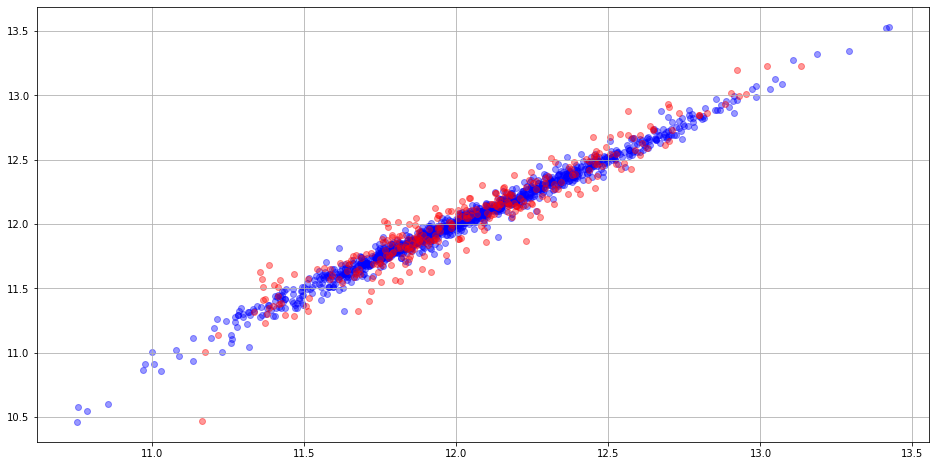

In [70]:
plt.figure(figsize=(16, 8))
plt.scatter(gs_rfr_fs.best_estimator_.predict(xtrain_fs), ytrain_fs, color='blue', alpha=0.4)
plt.scatter(gs_rfr_fs.best_estimator_.predict(xtest_fs), ytest_fs, color='red', alpha=0.4)
plt.grid(which='both')

In [71]:
train_scores = []
test_scores = []
train_rmse = []
test_rmse = []
best_par_list = []

# parameters to use
maxdepth = [20, 30, 40, 50, 60, 70]
minsamlf = [1, 3, 5]
minsamsplt = [2, 3, 5]
nestimators = [450, 500, 550, 600, 700]
oobscore = [True, False]
warmstart = [True, False]


gparam_rfr_fs = {'max_depth': maxdepth,
                  'min_samples_leaf': minsamlf,
                  'min_samples_split': minsamsplt,
                  'n_estimators': nestimators,
                  'oob_score': oobscore,
                  'warm_start': warmstart}

# setting parameters
gs_rfr_fs = ms.GridSearchCV(rfr, gparam_rfr_fs, cv=n_folds, refit=True, n_jobs=-1,
                             scoring='neg_root_mean_squared_error', return_train_score=True)

%time gs_rfr_fs.fit(xtrain_fs, ytrain_fs)

# setting up dataframe for results
train_scores.append(gs_rfr_fs.best_estimator_.score(xtrain_fs, ytrain_fs))
test_scores.append(gs_rfr_fs.best_estimator_.score(xtest_fs, ytest_fs))

# use rmse function from Self_Written_Functions_Sheet_Recover
train_rmse.append(rmse(gs_rfr_fs, ytrain_fs, xtrain_fs))
test_rmse.append(rmse(gs_rfr_fs, ytest_fs, xtest_fs))

# add the best parameters to the df
best_par_list.append(gs_rfr_fs.best_params_)

# find the difference btwn the rmses
diff_rmse = np.subtract(train_rmse, test_rmse)

# create dataframe
rfr_list_results = [train_scores, test_scores, train_rmse, test_rmse, diff_rmse]
rfr_res_df = pd.DataFrame(rfr_list_results).T
rfr_res_df.columns = ['TrainScores', 'TestScores', 'TrainRMSE', 'TestRMSE', 'DiffRMSE']
best_par_df = pd.DataFrame(best_par_list)
rfr_res_df = pd.concat([rfr_res_df, best_par_df], axis=1, sort=False)

rfr_res_df

C:\Users\tdcho\anaconda3\envs\proj3_env\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Wall time: 21min 30s


,TrainScores,TestScores,TrainRMSE,TestRMSE,DiffRMSE,max_depth,min_samples_leaf,min_samples_split,n_estimators,oob_score,warm_start
0,0.983054,0.916106,0.051597,0.119239,-0.067643,20,1,2,450,True,True


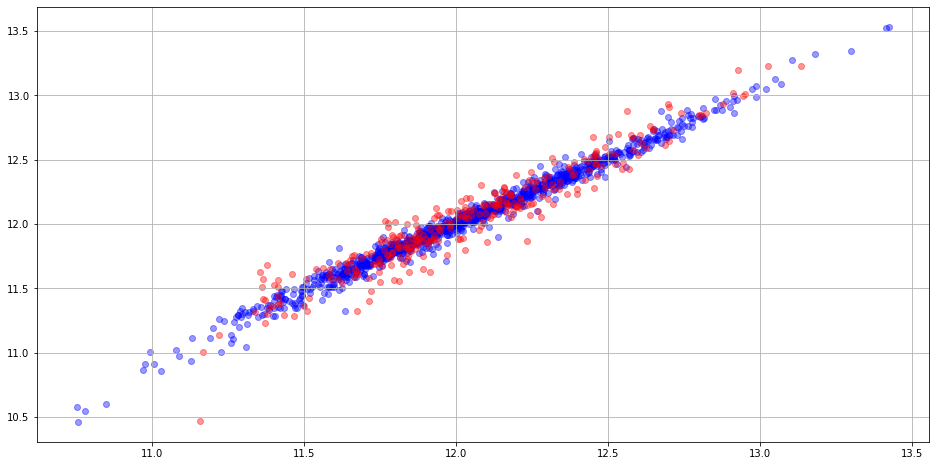

In [72]:
plt.figure(figsize=(16, 8))
plt.scatter(gs_rfr_fs.best_estimator_.predict(xtrain_fs), ytrain_fs, color='blue', alpha=0.4)
plt.scatter(gs_rfr_fs.best_estimator_.predict(xtest_fs), ytest_fs, color='red', alpha=0.4)
plt.grid(which='both')

In [77]:
train_scores = []
test_scores = []
train_rmse = []
test_rmse = []
best_par_list = []

# parameters to use
maxdepth = [15, 17, 20, 22, 25]
minsamlf = [1, 2, 3, 5]
minsamsplt = [2, 3, 5]
nestimators = [300, 325, 350, 375, 400, 425, 450, 475]
oobscore = [True, False]
warmstart = [True, False]


gparam_rfr_fs = {'max_depth': maxdepth,
                  'min_samples_leaf': minsamlf,
                  'min_samples_split': minsamsplt,
                  'n_estimators': nestimators,
                  'oob_score': oobscore,
                  'warm_start': warmstart}

# setting parameters
gs_rfr_fs = ms.GridSearchCV(rfr, gparam_rfr_fs, cv=n_folds, refit=True, n_jobs=-1,
                             scoring='neg_root_mean_squared_error', return_train_score=True)

%time gs_rfr_fs.fit(xtrain_fs, ytrain_fs)

# setting up dataframe for results
train_scores.append(gs_rfr_fs.best_estimator_.score(xtrain_fs, ytrain_fs))
test_scores.append(gs_rfr_fs.best_estimator_.score(xtest_fs, ytest_fs))

# use rmse function from Self_Written_Functions_Sheet_Recover
train_rmse.append(rmse(gs_rfr_fs, ytrain_fs, xtrain_fs))
test_rmse.append(rmse(gs_rfr_fs, ytest_fs, xtest_fs))

# add the best parameters to the df
best_par_list.append(gs_rfr_fs.best_params_)

# find the difference btwn the rmses
diff_rmse = np.subtract(train_rmse, test_rmse)

# create dataframe
rfr_list_results = [train_scores, test_scores, train_rmse, test_rmse, diff_rmse]
rfr_res_df = pd.DataFrame(rfr_list_results).T
rfr_res_df.columns = ['TrainScores', 'TestScores', 'TrainRMSE', 'TestRMSE', 'DiffRMSE']
best_par_df = pd.DataFrame(best_par_list)
rfr_res_df = pd.concat([rfr_res_df, best_par_df], axis=1, sort=False)

rfr_res_df

C:\Users\tdcho\anaconda3\envs\proj3_env\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Wall time: 26min 48s


,TrainScores,TestScores,TrainRMSE,TestRMSE,DiffRMSE,max_depth,min_samples_leaf,min_samples_split,n_estimators,oob_score,warm_start
0,0.981739,0.915869,0.053561,0.119407,-0.065846,25,1,3,475,True,True


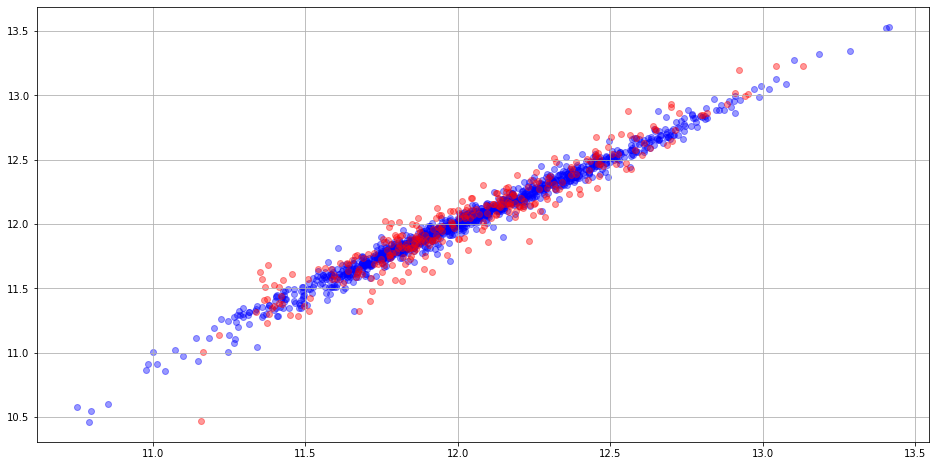

In [78]:
plt.figure(figsize=(16, 8))
plt.scatter(gs_rfr_fs.best_estimator_.predict(xtrain_fs), ytrain_fs, color='blue', alpha=0.4)
plt.scatter(gs_rfr_fs.best_estimator_.predict(xtest_fs), ytest_fs, color='red', alpha=0.4)
plt.grid(which='both')

In [89]:
train_scores = []
test_scores = []
train_rmse = []
test_rmse = []
best_par_list = []

# parameters to use
maxdepth = np.linspace(20, 50, 7)
minsamlf = [1, 3]
minsamsplt = [2, 3, 4, 5]
nestimators = np.linspace(450, 500, 11).astype(int)
oobscore = [True, False]
warmstart = [True, False]


gparam_rfr_fs = {'max_depth': maxdepth,
                  'min_samples_leaf': minsamlf,
                  'min_samples_split': minsamsplt,
                  'n_estimators': nestimators,
                  'oob_score': oobscore,
                  'warm_start': warmstart}

# setting parameters
gs_rfr_fs = ms.GridSearchCV(rfr, gparam_rfr_fs, cv=n_folds, refit=True, n_jobs=-1,
                             scoring='neg_root_mean_squared_error', return_train_score=True)

%time gs_rfr_fs.fit(xtrain_fs, ytrain_fs)

# setting up dataframe for results
train_scores.append(gs_rfr_fs.best_estimator_.score(xtrain_fs, ytrain_fs))
test_scores.append(gs_rfr_fs.best_estimator_.score(xtest_fs, ytest_fs))

# use rmse function from Self_Written_Functions_Sheet_Recover
train_rmse.append(rmse(gs_rfr_fs, ytrain_fs, xtrain_fs))
test_rmse.append(rmse(gs_rfr_fs, ytest_fs, xtest_fs))

# add the best parameters to the df
best_par_list.append(gs_rfr_fs.best_params_)

# find the difference btwn the rmses
diff_rmse = np.subtract(train_rmse, test_rmse)

# create dataframe
rfr_list_results = [train_scores, test_scores, train_rmse, test_rmse, diff_rmse]
rfr_res_df = pd.DataFrame(rfr_list_results).T
rfr_res_df.columns = ['TrainScores', 'TestScores', 'TrainRMSE', 'TestRMSE', 'DiffRMSE']
best_par_df = pd.DataFrame(best_par_list)
rfr_res_df = pd.concat([rfr_res_df, best_par_df], axis=1, sort=False)

rfr_res_df

C:\Users\tdcho\anaconda3\envs\proj3_env\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Wall time: 44min 34s


,TrainScores,TestScores,TrainRMSE,TestRMSE,DiffRMSE,max_depth,min_samples_leaf,min_samples_split,n_estimators,oob_score,warm_start
0,0.981758,0.915839,0.053532,0.119428,-0.065896,25.0,1,3,470,True,True


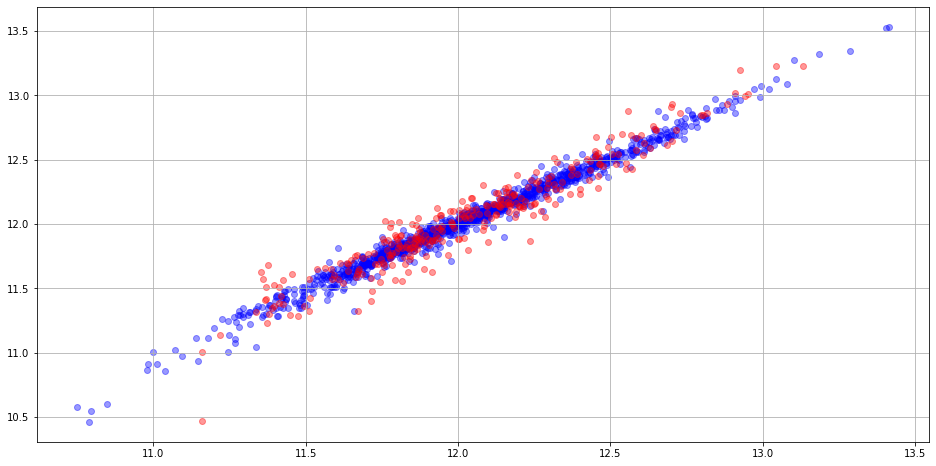

In [90]:
plt.figure(figsize=(16, 8))
plt.scatter(gs_rfr_fs.best_estimator_.predict(xtrain_fs), ytrain_fs, color='blue', alpha=0.4)
plt.scatter(gs_rfr_fs.best_estimator_.predict(xtest_fs), ytest_fs, color='red', alpha=0.4)
plt.grid(which='both')

### Test set is not improving

In [53]:
rfr_experimental = copy.deepcopy(rfr_df)

# Adding Seasons
experiment = copy.deepcopy(combo)

to_num = {'Jan':1, 'Feb':2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6,
          'Jul':7, 'Aug':8, 'Sep':9, 'Oct':10, 'Nov':11, 'Dec':12}

experiment['MoSold'] = experiment['MoSold'].map(to_num)

experiment['SeasonSold'] = 'Spring'

experiment.loc[(experiment['MoSold']==6) |
               (experiment['MoSold']==7) | 
               (experiment['MoSold']==8), 'SeasonSold'] = 'Summer'

experiment.loc[(experiment['MoSold']==9) |
               (experiment['MoSold']==10) |
               (experiment['MoSold']==11), 'SeasonSold'] = 'Fall'

experiment.loc[(experiment['MoSold']==12) | 
               (experiment['MoSold']==1) | 
               (experiment['MoSold']==2), 'SeasonSold'] = 'Winter'

# changing combo now so that I could use month number in experiment df
# https://stackoverflow.com/questions/37625334/python-pandas-convert-month-int-to-month-name
import calendar

# Adding Sold Date

experiment[['MoSold', 'YrSold']] = experiment[['MoSold', 'YrSold']].astype(int)

experiment['DateSold'] = pd.to_datetime(experiment.YrSold.astype(str) +\
                                        '-' + experiment.MoSold.astype(str))

experiment['MoSold'] = experiment ['MoSold'].apply(lambda x: calendar.month_abbr[x])

# adding WSJ Prime Rate
# https://en.wikipedia.org/wiki/Wall_Street_Journal_prime_rate
experiment['WSJPrime'] = 0
experiment.loc[experiment['DateSold']>='2005-12-01 00:00:00', 'WSJPrime'] = 7.25
experiment.loc[experiment['DateSold']>='2006-02-01 00:00:00', 'WSJPrime'] = 7.50
experiment.loc[experiment['DateSold']>='2006-04-01 00:00:00', 'WSJPrime'] = 7.75
experiment.loc[experiment['DateSold']>='2006-05-01 00:00:00', 'WSJPrime'] = 8.00
experiment.loc[experiment['DateSold']>='2006-07-01 00:00:00', 'WSJPrime'] = 8.25
experiment.loc[experiment['DateSold']>='2007-09-01 00:00:00', 'WSJPrime'] = 7.75
experiment.loc[experiment['DateSold']>='2007-11-01 00:00:00', 'WSJPrime'] = 7.50
experiment.loc[experiment['DateSold']>='2007-12-01 00:00:00', 'WSJPrime'] = 7.25
experiment.loc[experiment['DateSold']>='2008-01-01 00:00:00', 'WSJPrime'] = 6.50
experiment.loc[experiment['DateSold']>='2008-02-01 00:00:00', 'WSJPrime'] = 6.00
experiment.loc[experiment['DateSold']>='2008-03-01 00:00:00', 'WSJPrime'] = 5.25
experiment.loc[experiment['DateSold']>='2008-05-01 00:00:00', 'WSJPrime'] = 5.00
experiment.loc[experiment['DateSold']>='2008-10-01 00:00:00', 'WSJPrime'] = 4.50
experiment.loc[experiment['DateSold']>='2008-11-01 00:00:00', 'WSJPrime'] = 4.00
experiment.loc[experiment['DateSold']>='2008-12-01 00:00:00', 'WSJPrime'] = 3.25
experiment.loc[experiment['DateSold']>='2015-12-01 00:00:00', 'WSJPrime'] = 3.50

# for experimental dataset
to_paste = experiment[['DateSold', 'WSJPrime', 'MoSold', 'YrSold']]

rfr_df = rfr_df.drop(['MoSold'], axis=1)

new_cols = list(rfr_df.columns) + list(to_paste.columns)

rfr_experiment = pd.DataFrame(np.concatenate((rfr_df.loc[hp_index], to_paste.loc[hp_index]),
                                             axis=1), columns = new_cols)

# converting columns containing numbers to numeric type
for col in rfr_experiment.columns: 
    rfr_experiment[col] = rfr_experiment[col].astype('float', errors='ignore')

# dummify and scale the dataset
hp_experimental = copy.deepcopy(dum_scale(rfr_experiment))
hp_experimental_to_use = copy.deepcopy(hp_experimental.loc[hp_index])

hp_experimental_to_use

,TotalBsmtBaths,TotalBaths,YrsRemodToSold,BsmtFin,TotalLivSF,LotFrontage,LotArea,Street,Alley,Utilities,OverallQual,OverallCond,YearBuilt,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,PoolQC,Fence,MiscVal,DateSold,WSJPrime,YrSold,MSSubClass_1-1/2 STORY FINISHED ALL AGES,MSSubClass_1-STORY 1945 & OLDER,MSSubClass_1-STORY 1946 & NEWER ALL STYLES,MSSubClass_1-STORY PUD (Planned Unit Development) - 1946 & NEWER,MSSubClass_1-STORY W/FINISHED ATTIC ALL AGES,MSSubClass_2 FAMILY CONVERSION - ALL STYLES AND AGES,MSSubClass_2-1/2 STORY ALL AGES,MSSubClass_2-STORY 1945 & OLDER,MSSubClass_2-STORY 1946 & NEWER,MSSubClass_2-STORY PUD - 1946 & NEWER,MSSubClass_DUPLEX - ALL STYLES AND AGES,MSSubClass_PUD - MULTILEVEL - INCL SPLIT LEV/FOYER,MSSubClass_SPLIT FOYER,MSSubClass_SPLIT OR MULTI-LEVEL,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_TwnhsE,BldgType_TwnhsI,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_BrkComm,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CemntBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_WdShing,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_None,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,MoSold_Aug,MoSold_Dec,MoSold_Feb,MoSold_Jan,MoSold_Jul,MoSold_Jun,MoSold_Mar,MoSold_May,MoSold_Nov,MoSold_Oct,MoSold_Sep
0,0.333333,0.714286,0.083333,1.0,0.333761,0.150685,0.033420,1.0,0.0,1.0,0.666667,0.500,0.949275,0.122500,0.666667,0.50,0.8,0.75,0.25,1.000000,0.322669,0.166667,0.000000,0.064212,0.266999,1.0

In [15]:
state = 0

# setting up train and test sets
xtrain_exp, xtest_exp, ytrain_exp, ytest_exp = ms.train_test_split(hp_experimental_to_use,
                                                                   hp_logsp,
                                                                   test_size=0.2,
                                                                   random_state=state)

# Must flatten to fit
ytrain_exp = ytrain_exp.values.flatten()

# using standard kfold split
n_folds = ms.KFold(n_splits=5, random_state=state, shuffle=True)

In [16]:
train_scores = []
test_scores = []
train_rmse = []
test_rmse = []
best_par_list = []

# parameters to use
maxdepth = [5, 10, 50, 100, 500]
minsamlf = [1, 2, 3, 4, 5]
minsamsplt = [2, 3, 4, 5]
nestimators = [100, 250, 400, 500]
oobscore = [True, False]
warmstart = [True, False]


gparam_rfr_exp = {'max_depth': maxdepth,
                  'min_samples_leaf': minsamlf,
                  'min_samples_split': minsamsplt,
                  'n_estimators': nestimators,
                  'oob_score': oobscore,
                  'warm_start': warmstart}

# setting parameters
gs_rfr_exp = ms.GridSearchCV(rfr, gparam_rfr_exp, cv=n_folds, refit=True, n_jobs=-1,
                             scoring='neg_root_mean_squared_error', return_train_score=True)

%time gs_rfr_exp.fit(xtrain_exp, ytrain_exp)

# setting up dataframe for results
train_scores.append(gs_rfr_exp.best_estimator_.score(xtrain_exp, ytrain_exp))
test_scores.append(gs_rfr_exp.best_estimator_.score(xtest_exp, ytest_exp))

# use rmse function from Self_Written_Functions_Sheet_Recover
train_rmse.append(rmse(gs_rfr_exp, ytrain_exp, xtrain_exp))
test_rmse.append(rmse(gs_rfr_exp, ytest_exp, xtest_exp))

# add the best parameters to the df
best_par_list.append(gs_rfr_exp.best_params_)

# find the difference btwn the rmses
diff_rmse = np.subtract(train_rmse, test_rmse)

# create dataframe
rfr_list_results = [train_scores, test_scores, train_rmse, test_rmse, diff_rmse]
rfr_res_df = pd.DataFrame(rfr_list_results).T
rfr_res_df.columns = ['TrainScores', 'TestScores', 'TrainRMSE', 'TestRMSE', 'DiffRMSE']
best_par_df = pd.DataFrame(best_par_list)
rfr_res_df = pd.concat([rfr_res_df, best_par_df], axis=1, sort=False)

rfr_res_df

C:\Users\tdcho\anaconda3\envs\proj3_env\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Wall time: 18min 30s


,TrainScores,TestScores,TrainRMSE,TestRMSE,DiffRMSE,max_depth,min_samples_leaf,min_samples_split,n_estimators,oob_score,warm_start
0,0.982779,0.915396,0.052014,0.119743,-0.067729,50,1,2,500,True,True


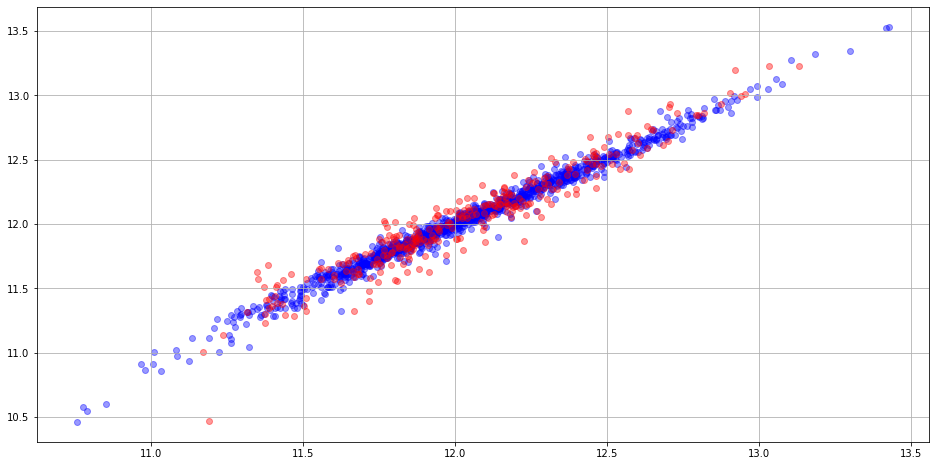

In [17]:
plt.figure(figsize=(16, 8))
plt.scatter(gs_rfr_exp.best_estimator_.predict(xtrain_exp), ytrain_exp, color='blue', alpha=0.4)
plt.scatter(gs_rfr_exp.best_estimator_.predict(xtest_exp), ytest_exp, color='red', alpha=0.4)
plt.grid(which='both')

In [18]:
train_scores = []
test_scores = []
train_rmse = []
test_rmse = []
best_par_list = []

# parameters to use
maxdepth = [25, 40, 50, 60, 75, 90]
minsamlf = [1, 2, 5]
minsamsplt = [2, 5]
nestimators = [450, 500, 550, 600, 700]
oobscore = [True, False]
warmstart = [True, False]


gparam_rfr_exp = {'max_depth': maxdepth,
                  'min_samples_leaf': minsamlf,
                  'min_samples_split': minsamsplt,
                  'n_estimators': nestimators,
                  'oob_score': oobscore,
                  'warm_start': warmstart}

# setting parameters
gs_rfr_exp = ms.GridSearchCV(rfr, gparam_rfr_exp, cv=n_folds, refit=True, n_jobs=-1,
                             scoring='neg_root_mean_squared_error', return_train_score=True)

%time gs_rfr_exp.fit(xtrain_exp, ytrain_exp)

# setting up dataframe for results
train_scores.append(gs_rfr_exp.best_estimator_.score(xtrain_exp, ytrain_exp))
test_scores.append(gs_rfr_exp.best_estimator_.score(xtest_exp, ytest_exp))

# use rmse function from Self_Written_Functions_Sheet_Recover
train_rmse.append(rmse(gs_rfr_exp, ytrain_exp, xtrain_exp))
test_rmse.append(rmse(gs_rfr_exp, ytest_exp, xtest_exp))

# add the best parameters to the df
best_par_list.append(gs_rfr_exp.best_params_)

# find the difference btwn the rmses
diff_rmse = np.subtract(train_rmse, test_rmse)

# create dataframe
rfr_list_results = [train_scores, test_scores, train_rmse, test_rmse, diff_rmse]
rfr_res_df = pd.DataFrame(rfr_list_results).T
rfr_res_df.columns = ['TrainScores', 'TestScores', 'TrainRMSE', 'TestRMSE', 'DiffRMSE']
best_par_df = pd.DataFrame(best_par_list)
rfr_res_df = pd.concat([rfr_res_df, best_par_df], axis=1, sort=False)

rfr_res_df

C:\Users\tdcho\anaconda3\envs\proj3_env\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Wall time: 15min 32s


,TrainScores,TestScores,TrainRMSE,TestRMSE,DiffRMSE,max_depth,min_samples_leaf,min_samples_split,n_estimators,oob_score,warm_start
0,0.982779,0.915396,0.052014,0.119743,-0.067729,40,1,2,500,True,True


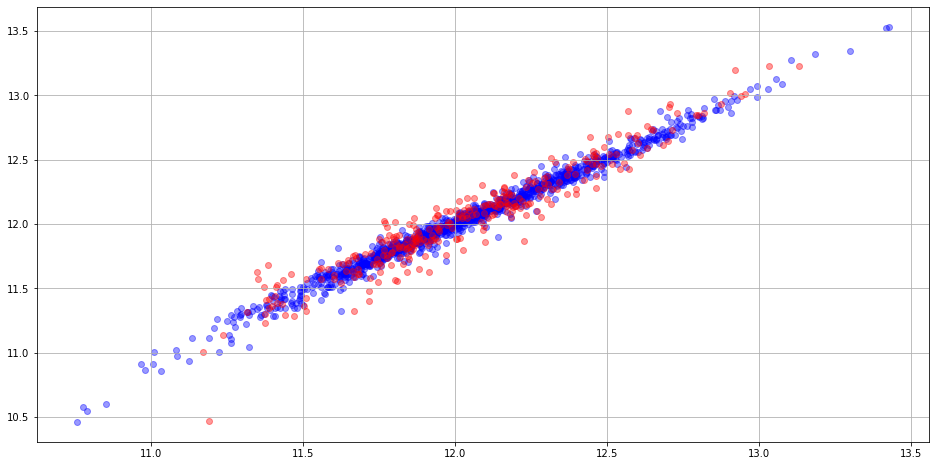

In [19]:
plt.figure(figsize=(16, 8))
plt.scatter(gs_rfr_exp.best_estimator_.predict(xtrain_exp), ytrain_exp, color='blue', alpha=0.4)
plt.scatter(gs_rfr_exp.best_estimator_.predict(xtest_exp), ytest_exp, color='red', alpha=0.4)
plt.grid(which='both')

In [20]:
train_scores = []
test_scores = []
train_rmse = []
test_rmse = []
best_par_list = []

# parameters to use
maxdepth = [30, 35, 40, 45]
minsamlf = [1]
minsamsplt = [2]
nestimators = [475, 490, 500, 510, 525]
oobscore = [True]
warmstart = [True]


gparam_rfr_exp = {'max_depth': maxdepth,
                  'min_samples_leaf': minsamlf,
                  'min_samples_split': minsamsplt,
                  'n_estimators': nestimators,
                  'oob_score': oobscore,
                  'warm_start': warmstart}

# setting parameters
gs_rfr_exp = ms.GridSearchCV(rfr, gparam_rfr_exp, cv=n_folds, refit=True, n_jobs=-1,
                             scoring='neg_root_mean_squared_error', return_train_score=True)

%time gs_rfr_exp.fit(xtrain_exp, ytrain_exp)

# setting up dataframe for results
train_scores.append(gs_rfr_exp.best_estimator_.score(xtrain_exp, ytrain_exp))
test_scores.append(gs_rfr_exp.best_estimator_.score(xtest_exp, ytest_exp))

# use rmse function from Self_Written_Functions_Sheet_Recover
train_rmse.append(rmse(gs_rfr_exp, ytrain_exp, xtrain_exp))
test_rmse.append(rmse(gs_rfr_exp, ytest_exp, xtest_exp))

# add the best parameters to the df
best_par_list.append(gs_rfr_exp.best_params_)

# find the difference btwn the rmses
diff_rmse = np.subtract(train_rmse, test_rmse)

# create dataframe
rfr_list_results = [train_scores, test_scores, train_rmse, test_rmse, diff_rmse]
rfr_res_df = pd.DataFrame(rfr_list_results).T
rfr_res_df.columns = ['TrainScores', 'TestScores', 'TrainRMSE', 'TestRMSE', 'DiffRMSE']
best_par_df = pd.DataFrame(best_par_list)
rfr_res_df = pd.concat([rfr_res_df, best_par_df], axis=1, sort=False)

rfr_res_df

C:\Users\tdcho\anaconda3\envs\proj3_env\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Wall time: 42 s


,TrainScores,TestScores,TrainRMSE,TestRMSE,DiffRMSE,max_depth,min_samples_leaf,min_samples_split,n_estimators,oob_score,warm_start
0,0.982782,0.91542,0.052009,0.119725,-0.067716,30,1,2,490,True,True


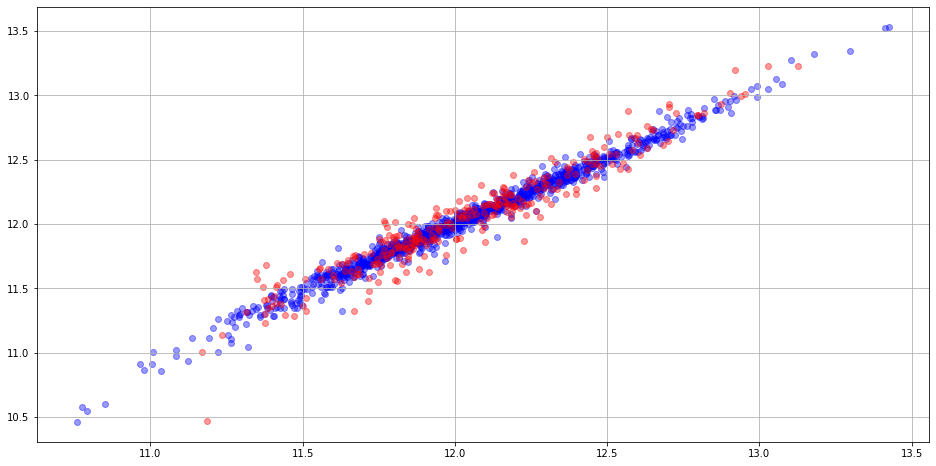

In [21]:
plt.figure(figsize=(16, 8))
plt.scatter(gs_rfr_exp.best_estimator_.predict(xtrain_exp), ytrain_exp, color='blue', alpha=0.4)
plt.scatter(gs_rfr_exp.best_estimator_.predict(xtest_exp), ytest_exp, color='red', alpha=0.4)
plt.grid(which='both')

In [22]:
train_scores = []
test_scores = []
train_rmse = []
test_rmse = []
best_par_list = []

# parameters to use
maxdepth = [25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
minsamlf = [1]
minsamsplt = [2]
nestimators = [480, 485, 490, 495, 500]
oobscore = [True]
warmstart = [True]


gparam_rfr_exp = {'max_depth': maxdepth,
                  'min_samples_leaf': minsamlf,
                  'min_samples_split': minsamsplt,
                  'n_estimators': nestimators,
                  'oob_score': oobscore,
                  'warm_start': warmstart}

# setting parameters
gs_rfr_exp = ms.GridSearchCV(rfr, gparam_rfr_exp, cv=n_folds, refit=True, n_jobs=-1,
                             scoring='neg_root_mean_squared_error', return_train_score=True)

%time gs_rfr_exp.fit(xtrain_exp, ytrain_exp)

# setting up dataframe for results
train_scores.append(gs_rfr_exp.best_estimator_.score(xtrain_exp, ytrain_exp))
test_scores.append(gs_rfr_exp.best_estimator_.score(xtest_exp, ytest_exp))

# use rmse function from Self_Written_Functions_Sheet_Recover
train_rmse.append(rmse(gs_rfr_exp, ytrain_exp, xtrain_exp))
test_rmse.append(rmse(gs_rfr_exp, ytest_exp, xtest_exp))

# add the best parameters to the df
best_par_list.append(gs_rfr_exp.best_params_)

# find the difference btwn the rmses
diff_rmse = np.subtract(train_rmse, test_rmse)

# create dataframe
rfr_list_results = [train_scores, test_scores, train_rmse, test_rmse, diff_rmse]
rfr_res_df = pd.DataFrame(rfr_list_results).T
rfr_res_df.columns = ['TrainScores', 'TestScores', 'TrainRMSE', 'TestRMSE', 'DiffRMSE']
best_par_df = pd.DataFrame(best_par_list)
rfr_res_df = pd.concat([rfr_res_df, best_par_df], axis=1, sort=False)

rfr_res_df

C:\Users\tdcho\anaconda3\envs\proj3_env\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Wall time: 1min 22s


,TrainScores,TestScores,TrainRMSE,TestRMSE,DiffRMSE,max_depth,min_samples_leaf,min_samples_split,n_estimators,oob_score,warm_start
0,0.982782,0.91542,0.052009,0.119725,-0.067716,30,1,2,490,True,True


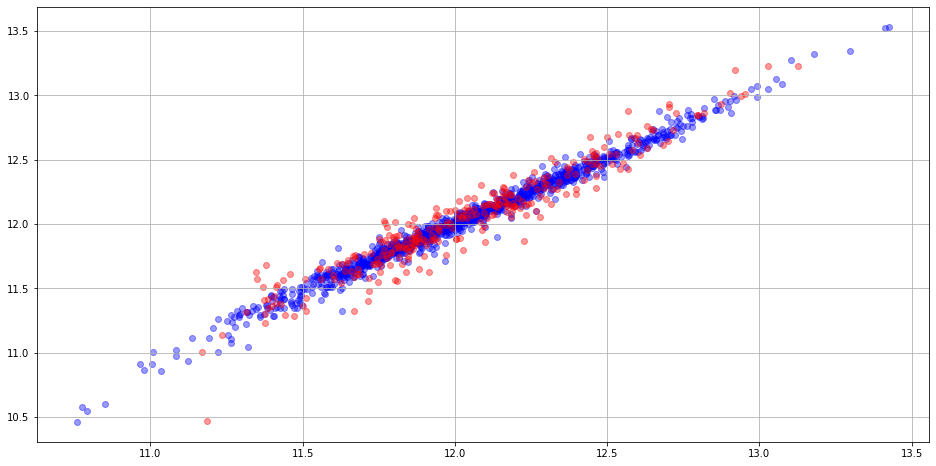

In [23]:
plt.figure(figsize=(16, 8))
plt.scatter(gs_rfr_exp.best_estimator_.predict(xtrain_exp), ytrain_exp, color='blue', alpha=0.4)
plt.scatter(gs_rfr_exp.best_estimator_.predict(xtest_exp), ytest_exp, color='red', alpha=0.4)
plt.grid(which='both')

In [24]:
train_scores = []
test_scores = []
train_rmse = []
test_rmse = []
best_par_list = []

# parameters to use
maxdepth = [30]
minsamlf = [1]
minsamsplt = [2]
nestimators = [486, 487, 488, 489, 490, 491, 492, 493, 494]
oobscore = [True]
warmstart = [True]


gparam_rfr_exp = {'max_depth': maxdepth,
                  'min_samples_leaf': minsamlf,
                  'min_samples_split': minsamsplt,
                  'n_estimators': nestimators,
                  'oob_score': oobscore,
                  'warm_start': warmstart}

# setting parameters
gs_rfr_exp = ms.GridSearchCV(rfr, gparam_rfr_exp, cv=n_folds, refit=True, n_jobs=-1,
                             scoring='neg_root_mean_squared_error', return_train_score=True)

%time gs_rfr_exp.fit(xtrain_exp, ytrain_exp)

# setting up dataframe for results
train_scores.append(gs_rfr_exp.best_estimator_.score(xtrain_exp, ytrain_exp))
test_scores.append(gs_rfr_exp.best_estimator_.score(xtest_exp, ytest_exp))

# use rmse function from Self_Written_Functions_Sheet_Recover
train_rmse.append(rmse(gs_rfr_exp, ytrain_exp, xtrain_exp))
test_rmse.append(rmse(gs_rfr_exp, ytest_exp, xtest_exp))

# add the best parameters to the df
best_par_list.append(gs_rfr_exp.best_params_)

# find the difference btwn the rmses
diff_rmse = np.subtract(train_rmse, test_rmse)

# create dataframe
rfr_list_results = [train_scores, test_scores, train_rmse, test_rmse, diff_rmse]
rfr_res_df = pd.DataFrame(rfr_list_results).T
rfr_res_df.columns = ['TrainScores', 'TestScores', 'TrainRMSE', 'TestRMSE', 'DiffRMSE']
best_par_df = pd.DataFrame(best_par_list)
rfr_res_df = pd.concat([rfr_res_df, best_par_df], axis=1, sort=False)

rfr_res_df

C:\Users\tdcho\anaconda3\envs\proj3_env\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Wall time: 24 s


,TrainScores,TestScores,TrainRMSE,TestRMSE,DiffRMSE,max_depth,min_samples_leaf,min_samples_split,n_estimators,oob_score,warm_start
0,0.982784,0.915473,0.052005,0.119688,-0.067683,30,1,2,493,True,True


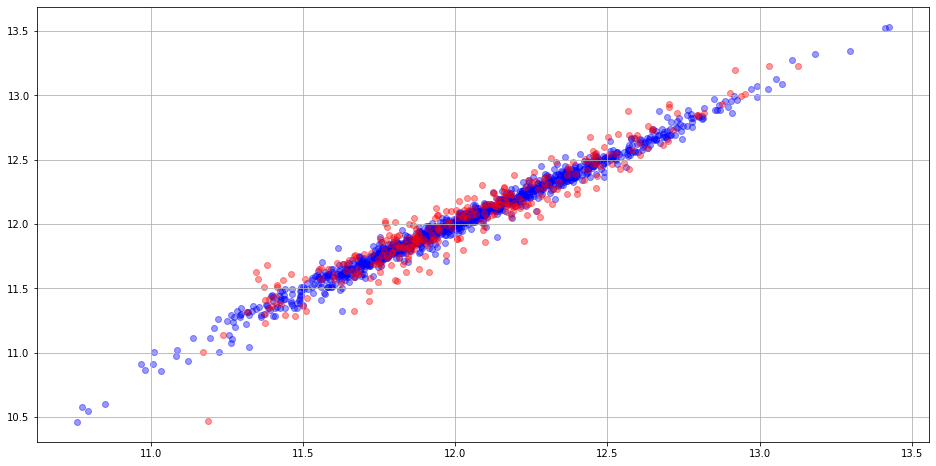

In [25]:
plt.figure(figsize=(16, 8))
plt.scatter(gs_rfr_exp.best_estimator_.predict(xtrain_exp), ytrain_exp, color='blue', alpha=0.4)
plt.scatter(gs_rfr_exp.best_estimator_.predict(xtest_exp), ytest_exp, color='red', alpha=0.4)
plt.grid(which='both')

In [26]:
train_scores = []
test_scores = []
train_rmse = []
test_rmse = []
best_par_list = []

# parameters to use
maxdepth = [30]
minsamlf = [1]
minsamsplt = [2]
nestimators = [493]
oobscore = [True]
warmstart = [True]


gparam_rfr_exp = {'max_depth': maxdepth,
                  'min_samples_leaf': minsamlf,
                  'min_samples_split': minsamsplt,
                  'n_estimators': nestimators,
                  'oob_score': oobscore,
                  'warm_start': warmstart}

# setting parameters
gs_rfr_exp = ms.GridSearchCV(rfr, gparam_rfr_exp, cv=n_folds, refit=True, n_jobs=-1,
                             scoring='neg_root_mean_squared_error', return_train_score=True)

%time gs_rfr_exp.fit(xtrain_exp, ytrain_exp)

# setting up dataframe for results
train_scores.append(gs_rfr_exp.best_estimator_.score(xtrain_exp, ytrain_exp))
test_scores.append(gs_rfr_exp.best_estimator_.score(xtest_exp, ytest_exp))

# use rmse function from Self_Written_Functions_Sheet_Recover
train_rmse.append(rmse(gs_rfr_exp, ytrain_exp, xtrain_exp))
test_rmse.append(rmse(gs_rfr_exp, ytest_exp, xtest_exp))

# add the best parameters to the df
best_par_list.append(gs_rfr_exp.best_params_)

# find the difference btwn the rmses
diff_rmse = np.subtract(train_rmse, test_rmse)

# create dataframe
rfr_list_results = [train_scores, test_scores, train_rmse, test_rmse, diff_rmse]
rfr_res_df = pd.DataFrame(rfr_list_results).T
rfr_res_df.columns = ['TrainScores', 'TestScores', 'TrainRMSE', 'TestRMSE', 'DiffRMSE']
best_par_df = pd.DataFrame(best_par_list)
rfr_res_df = pd.concat([rfr_res_df, best_par_df], axis=1, sort=False)

rfr_res_df

C:\Users\tdcho\anaconda3\envs\proj3_env\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Wall time: 15.4 s


,TrainScores,TestScores,TrainRMSE,TestRMSE,DiffRMSE,max_depth,min_samples_leaf,min_samples_split,n_estimators,oob_score,warm_start
0,0.982784,0.915473,0.052005,0.119688,-0.067683,30,1,2,493,True,True


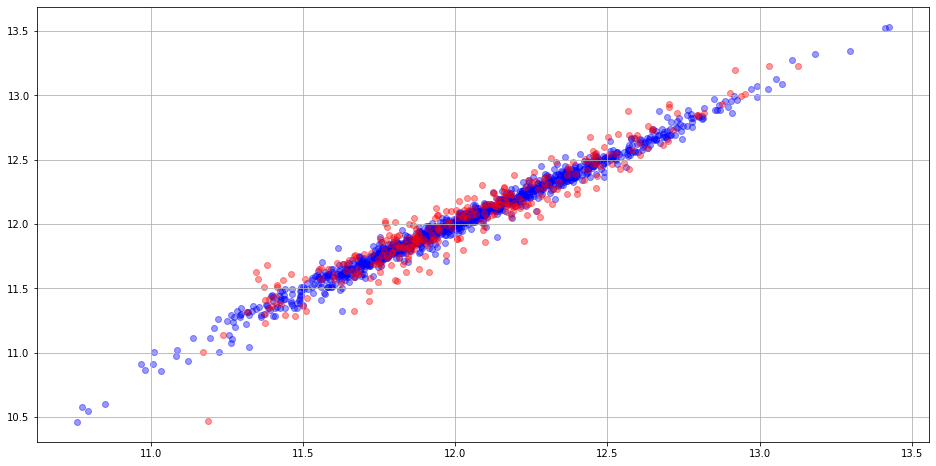

In [27]:
plt.figure(figsize=(16, 8))
plt.scatter(gs_rfr_exp.best_estimator_.predict(xtrain_exp), ytrain_exp, color='blue', alpha=0.4)
plt.scatter(gs_rfr_exp.best_estimator_.predict(xtest_exp), ytest_exp, color='red', alpha=0.4)
plt.grid(which='both')

# Filtered Dataset

In [92]:
sorted_importance_rfr_exp = sorted(zip(hp_experimental_to_use,
                                       gs_rfr_exp.best_estimator_.feature_importances_),
                               key=lambda t:t[1], reverse=True)

filtered_sorted_importance_rfr_exp = [x for x in sorted_importance_rfr_exp if x[1]>0]

df_filter_sort_rfr_exp = [x[0] for x in filtered_sorted_importance_rfr_exp]

hp_exp_filtrsrt = hp_experimental_to_use[df_filter_sort_rfr_exp]
hp_exp_filtrsrt

,OverallQual,TotalLivSF,GarageArea,GrLivArea,TotalBsmtSF,GarageCars,YrsRemodToSold,YearBuilt,LotArea,OverallCond,CentralAir,1stFlrSF,GarageYrBlt,FireplaceQu_None,BsmtUnfSF,LotFrontage,KitchenQual,TotalBaths,GarageCond,2ndFlrSF,MSZoning_RM,GarageType_Detchd,BsmtQual,BsmtFinSF1,ExterCond,DateSold,GarageFinish,WoodDeckSF,PavedDrive,MasVnrArea,Functional,Fence,TotRmsAbvGrd,GarageQual,HeatingQC,ExterQual,LotShape_Reg,MSZoning_RL,SaleCondition_Normal,BsmtFinType1,WSJPrime,BsmtExposure,MoSold_Dec,BedroomAbvGr,MSSubClass_2-STORY 1946 & NEWER,GarageType_Attchd,Condition1_Norm,Neighborhood_IDOTRR,SaleCondition_Family,FireplaceQu_Gd,Neighborhood_NAmes,HalfBath,Neighborhood_OldTown,KitchenAbvGr,YrSold,FireplaceQu_Po,Neighborhood_Edwards,LotConfig_Inside,RoofStyle_Gable,MSSubClass_1-STORY 1945 & OLDER,Exterior2nd_VinylSd,Neighborhood_Crawfor,LandContour_Lvl,Alley,GarageType_None,FullBath,BsmtFinSF2,Electrical,SaleType_WD,TotalBsmtBaths,BsmtCond,Foundation_CBlock,MoSold_Nov,RoofStyle_Hip,MoSold_Jul,SaleCondition_Partial,SaleType_New,Foundation_PConc,MoSold_Feb,Exterior1st_VinylSd,Exterior1st_Wd Sdng,MSSubClass_1-1/2 STORY FINISHED ALL AGES,HouseStyle_2Story,Neighborhood_Sawyer,MoSold_Jun,BsmtFinType2,MoSold_Aug,Exterior1st_MetalSd,MoSold_Mar,MoSold_May,Neighborhood_NWAmes,FireplaceQu_TA,Neighborhood_StoneBr,HouseStyle_1Story,LandContour_HLS,MasVnrType_None,MoSold_Jan,LandSlope_Mod,Exterior1st_Plywood,Exterior1st_BrkFace,MSSubClass_1-STORY 1946 & NEWER ALL STYLES,Exterior2nd_Plywood,Exterior1st_HdBoard,LowQualFinSF,MasVnrType_BrkFace,Exterior2nd_MetalSd,MoSold_Oct,Exterior2nd_Wd Sdng,Heating_OthW,Exterior2nd_HdBoard,MSSubClass_2-STORY PUD - 1946 & NEWER,Neighborhood_CollgCr,LotConfig_CulDSac,MoSold_Sep,Neighborhood_ClearCr,Neighborhood_BrkSide,BsmtFin,Neighborhood_NridgHt,Heating_GasA,MiscVal,MasVnrType_Stone,Condition1_Feedr,Neighborhood_Somerst,GarageType_CarPort,Neighborhood_NoRidge,RoofStyle_Gambrel,MSSubClass_2-STORY 1945 & OLDER,LandContour_Low,Neighborhood_SWISU,Exterior2nd_BrkFace,LotConfig_FR2,Neighborhood_Mitchel,Exterior2nd_BrkComm,Condition1_RRAe,MiscFeature_None,Exterior1st_CemntBd,SaleCondition_Alloca,Neighborhood_Timber,Exterior2nd_CemntBd,Condition1_RRAn,Exterior2nd_Stucco,MSSubClass_SPLIT OR MULTI-LEVEL,Neighborhood_MeadowV,Heating_GasW,LotShape_IR2,Neighborhood_Gilbert,GarageType_BuiltIn,Heating_Grav,Street,MSSubClass_2 FAMILY CONVERSION - ALL STYLES AND AGES,Condition1_PosN,MSSubClass_DUPLEX - ALL STYLES AND AGES,Neighborhood_SawyerW,Exterior1st_BrkComm,BldgType_TwnhsE,Exterior2nd_WdShing,MSZoning_FV,MSSubClass_2-1/2 STORY ALL AGES,Condition2_Feedr,BldgType_Duplex,Condition2_Norm,MiscFeature_Shed,HouseStyle_SLvl,MSSubClass_1-STORY PUD (Planned Unit Development) - 1946 & NEWER,MSZoning_RH,MSSubClass_1-STORY W/FINISHED ATTIC ALL AGES,Exterior1st_Stucco,SaleType_ConLD,Condition1_PosA,RoofMatl_Tar&Grv,FireplaceQu_Fa,HouseStyle_1.5Unf,LandSlope_Sev,BldgType_TwnhsI,BldgType_2fmCon,LotShape_IR3,GarageType_Basment,SaleType_CWD,HouseStyle_2.5Unf,RoofMatl_WdShngl,Exterior1st_WdShing,Exterior2nd_AsphShn,Neighborhood_BrDale,PoolQC,HouseStyle_SFoyer,Neighborhood_NPkVill,Foundation_Slab,Foundation_Stone,SaleType_ConLw,Neighborhood_Veenker,HouseStyle_2.5Fin,RoofMatl_Metal,Exterior1st_AsphShn,LotConfig_FR3,MSSubClass_SPLIT FOYER,RoofStyle_Mansard,Exterior2nd_ImStucc,SaleType_Oth,Exterior2nd_Stone,Exterior1st_CBlock,SaleType_ConLI,MiscFeature_Othr,RoofMatl_WdShake,MSSubClass_PUD - MULTILEVEL - INCL SPLIT LEV/FOYER,Foundation_Wood,Utilities,Exterior2nd_Other,Exterior2nd_CBlock,SaleCondition_AdjLand,Condition1_RRNn,Heating_Wall,Condition1_RRNe,Condition2_PosN,RoofMatl_Membran,Neighborhood_Blueste,Condition2_PosA,Condition2_RRAn,Exterior1st_Stone,Condition2_RRNn,RoofMatl_Roll
0,0.666667,0.333761,0.394245,0.332207,0.266999,0.50,0.083333,0.949275,0.033420,0.500,1.0,0.180373,0.996517,1.0,0.064212,0.150685,0.666667,0.714286,0.6,0.413559,0.0,0.0,0.8,0.322669,0.50,0.463459,0.666667,0.000000,1.0,0.122500,1.000000,0.0,0.500000,0.6,1.00,0.666667,1.0,1

In [93]:
state = 0

# setting up train and test sets
xtrain_expfs, xtest_expfs, ytrain_expfs, ytest_expfs = ms.train_test_split(hp_exp_filtrsrt,
                                                                           hp_logsp,
                                                                           test_size=0.2,
                                                                           random_state=state)

# Must flatten to fit
ytrain_expfs = ytrain_expfs.values.flatten()

# using standard kfold split
n_folds = ms.KFold(n_splits=5, random_state=state, shuffle=True)

In [94]:
train_scores = []
test_scores = []
train_rmse = []
test_rmse = []
best_par_list = []

# parameters to use
maxdepth = [5, 10, 50, 100, 500]
minsamlf = [1, 2, 3, 4, 5]
minsamsplt = [2, 3, 4, 5]
nestimators = [100, 250, 400, 500]
oobscore = [True, False]
warmstart = [True, False]


gparam_rfr_expfs = {'max_depth': maxdepth,
                  'min_samples_leaf': minsamlf,
                  'min_samples_split': minsamsplt,
                  'n_estimators': nestimators,
                  'oob_score': oobscore,
                  'warm_start': warmstart}

# setting parameters
gs_rfr_expfs = ms.GridSearchCV(rfr, gparam_rfr_expfs, cv=n_folds, refit=True, n_jobs=-1,
                             scoring='neg_root_mean_squared_error', return_train_score=True)

%time gs_rfr_expfs.fit(xtrain_expfs, ytrain_expfs)

# setting up dataframe for results
train_scores.append(gs_rfr_expfs.best_estimator_.score(xtrain_expfs, ytrain_expfs))
test_scores.append(gs_rfr_expfs.best_estimator_.score(xtest_expfs, ytest_expfs))

# use rmse function from Self_Written_Functions_Sheet_Recover
train_rmse.append(rmse(gs_rfr_expfs, ytrain_expfs, xtrain_expfs))
test_rmse.append(rmse(gs_rfr_expfs, ytest_expfs, xtest_expfs))

# add the best parameters to the df
best_par_list.append(gs_rfr_expfs.best_params_)

# find the difference btwn the rmses
diff_rmse = np.subtract(train_rmse, test_rmse)

# create dataframe
rfr_list_results = [train_scores, test_scores, train_rmse, test_rmse, diff_rmse]
rfr_res_df = pd.DataFrame(rfr_list_results).T
rfr_res_df.columns = ['TrainScores', 'TestScores', 'TrainRMSE', 'TestRMSE', 'DiffRMSE']
best_par_df = pd.DataFrame(best_par_list)
rfr_res_df = pd.concat([rfr_res_df, best_par_df], axis=1, sort=False)

rfr_res_df

C:\Users\tdcho\anaconda3\envs\proj3_env\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Wall time: 16min 34s


,TrainScores,TestScores,TrainRMSE,TestRMSE,DiffRMSE,max_depth,min_samples_leaf,min_samples_split,n_estimators,oob_score,warm_start
0,0.981643,0.914674,0.053701,0.120252,-0.066551,50,1,3,500,True,True


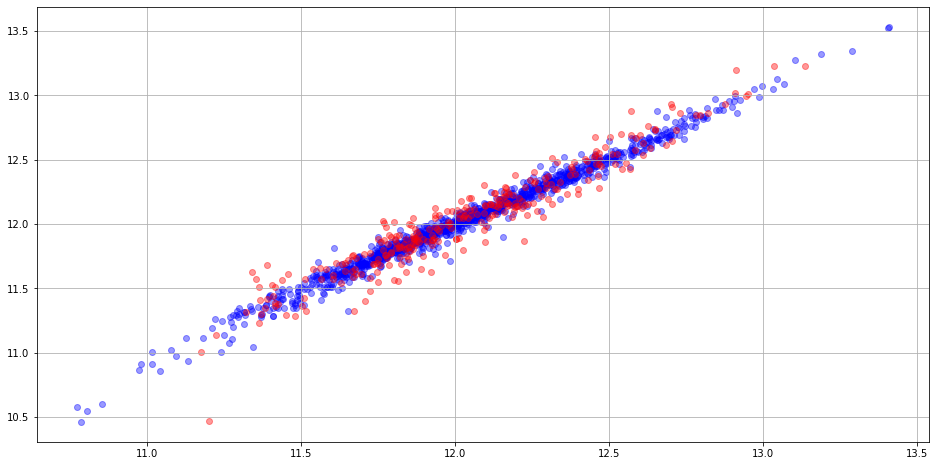

In [95]:
plt.figure(figsize=(16, 8))
plt.scatter(gs_rfr_expfs.best_estimator_.predict(xtrain_expfs), ytrain_expfs, color='blue', alpha=0.4)
plt.scatter(gs_rfr_expfs.best_estimator_.predict(xtest_expfs), ytest_expfs, color='red', alpha=0.4)
plt.grid(which='both')

# BEST PARAM

In [ ]:
# make copies of the original df to edit each individually according to the best scores/feat eng pair
rfr_df = copy.deepcopy(combo_nonedit)

# copy and paste the functions from the dictionary results above
rfr_feat_eng = [totallivsf_add, bsmtfin_add, yrsremodtosold_add, totalbaths_add, totalbsmtbaths_add, 
                drop_porches, drop_yrsoldremod, drop_fireplaces, drop_poolarea, drop_bsmtbaths]

for feat in rfr_feat_eng:
    feat(rfr_df)

# dummify and scale the dataset
hp_full_strd = copy.deepcopy(dum_scale(rfr_df))

hp_full_strd_to_use = copy.deepcopy(hp_full_strd.loc[hp_index])

state = 0

# setting up train and test sets
xtrain, xtest, ytrain, ytest = ms.train_test_split(hp_full_strd_to_use,
                                                   hp_logsp,
                                                   test_size=0.2,
                                                   random_state=state)

# Must flatten to fit
ytrain = ytrain.values.flatten()

# using standard kfold split
n_folds = ms.KFold(n_splits=5, random_state=state, shuffle=True)

rfr = RandomForestRegressor(random_state=0)

# parameters to use
maxdepth = [50]
minsamlf = [1]
minsamsplt = [2]
nestimators = [500]
oobscore = [True]
warmstart = [True]

gparam_rfr = {'max_depth': maxdepth,
              'min_samples_leaf': minsamlf,
              'min_samples_split': minsamsplt,
              'n_estimators': nestimators,
              'oob_score': oobscore,
              'warm_start': warmstart}

# setting parameters
gs_rfr = ms.GridSearchCV(rfr, gparam_rfr, cv=n_folds, refit=True, n_jobs=-1,
                           scoring='neg_root_mean_squared_error', return_train_score=True)

%time gs_rfr.fit(xtrain, ytrain)